## Introduction

This notebook is the code that was used for the analysis of this research paper:

__The FLOod Probability Interpolation Tool (FLOPIT): A Simple
Tool to Improve Spatial Flood Probability Quantification
and Communication__

__Authors__: Mahkameh Zarekarizi (1,2,*), K. Joel Roop-Eckart (3) , Sanjib Sharma (1), and Klaus Keller (1,3)

1: Earth and Environmental Systems Institute, Pennsylvania State University, University Park, PA 16802, USA
2: Jupiter Intelligence, San Mateo, CA 94401, USA
3: Department of Geosciences, Pennsylvania State University, University Park, PA 16802, USA
*Author to whom correspondence should be addressed (mahkameh.zare@gmail.com).

__Author and copyright__: Mahkameh Zarekarizi, Jupiter Intelligence, and Pennsylvania State University  
This notebook is written by Mahkameh Zarekarizi, while at Jupiter Intelligence 

__Distributed under the GNU general public license__

__Disclaimer__ : The datasets, software tools, results, and any other resources associated with FLOPIT
and this manuscript are intended for academic research and education (not for real-world decisionmaking) and provided as-is without warranty of any kind, express or implied. In no event shall the
authors or copyright holders be liable for any claim, damages, or other liability in connection with
the use of these resources

__Acknowledgement__: Special thanks to __Dr. Luke Madaus__ for contributing to this code by writing the function for filling the NaNs with their nearest neighbor that is not NaN


## Import libraries needed throughout the notebook

In [ ]:
import xarray
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from utils import *
import affine
from scipy import interpolate
import pandas as pd

## Indicate data paths 

In this section, we save paths for all case studies. We save paths for flood rasters and elevation data. We also indicate the return period associated with each raster provided. Finally, we indicate if the rasters are depth or water surface elevation (WSE)

In [7]:
flood_rasters_path_list_muncy = ['input_data/muncy/depth_10pct_projected_clipped.tif',
                           'input_data/muncy/depth_02pct_projected_clipped.tif',
                           'input_data/muncy/depth_01pct_projected_clipped.tif',
                           'input_data/muncy/depth_0_2pct_projected_clipped.tif']
elevation_raster_path_muncy = 'input_data/muncy/Muncy_dem_resampled.tif'
raster_return_periods_muncy = np.array([10,50,100,500])
depth_or_wse_muncy = 'depth'
area_name_muncy = 'muncy'

flood_rasters_path_list_selinsgrove = ['input_data/selinsgrove/dg_10pct_clip.tif',
                                 'input_data/selinsgrove/dg_4pct_clip.tif',
                                 'input_data/selinsgrove/dg_2pct_clip.tif',
                                 'input_data/selinsgrove/dg_1pct_clip.tif',
                                 'input_data/selinsgrove/dg_02pct_clip.tif']
raster_return_periods_selinsgrove = np.array([10,25,50,100,500])
elevation_raster_path_selinsgrove = 'input_data/selinsgrove/Sellinsgrove_DEM_clip1.tif'
depth_or_wse_selinsgrove = 'depth'
area_name_selinsgrove = 'selinsgrove'

flood_rasters_path_list_houston = ['input_data/houston/wse_10pct_clipped_resampled.tif',
                                   'input_data/houston/wse_2pct_clipped_resampled.tif',
                                   'input_data/houston/wse_1pct_clipped_resampled.tif',
                                   'input_data/houston/wse_02pct_clipped_resampled.tif']
raster_return_periods_houston = np.array([10,50,100,500])
elevation_raster_path_houston = 'input_data/houston/ned19_n29x75_w095x50_tx_houstoncity_2008_clipped_feet.tif'
depth_or_wse_houston = 'wse'
area_name_houston = 'houston'

## Indicate the study area 

We defined all paths for all three case studies in the previous section. Now, we determine the study area we want to run FLOPIT for 

In [1]:
area_name = area_name_houston # the name of the study area. This is be used in the name of the genrated outputs 
raster_return_periods = raster_return_periods_houston # return periods for the provided flood rasters 
flood_rasters_path_list = flood_rasters_path_list_houston # paths to flood rasters 
depth_or_wse = depth_or_wse_houston # Are these provided flood rasters depth or water surfce elevation
elevation_raster = elevation_raster_path_houston # path to elevation raster 

NameError: name 'area_name_houston' is not defined

## Note 

One part of FLOPIT that is quite time consuming is filling the NaNs with their nearest neighbor that has a value (we call this part backfilling). At this point, the user has two options: 1. let FLOPIT handel backfilling internally (this means FLOPIT will take more time) and 2. Run the backfilling separately, save the backfilled data and then run FLOPIT. The advantage of this option is that if you want to run FLOPIT multiple times, it significantly reduces the computational time. If you choose the second option, backfilled data will be saved locally as nc files. 

## METHOD 1: Run FLOPIT (runs backfilling internally)

In [ ]:
%%time
FLOPIT(
        flood_rasters_path_list = flood_rasters_path_list,
        input_return_periods = raster_return_periods , 
        elevation_raster = elevation_raster,
        depth_or_wse = depth_or_wse,
        depth_units = ['ft']*len(flood_rasters_path_list),
        dem_units = 'ft',
        interpolation_method = m,
        aep_raster_generate = 1,
        aep_map_generate = 1,
        flood_zone_return_period = [20,200],
        flood_zone_raster_generate = 1,
        flood_zone_map_generate = 1,
        extrapolate = 0,
        input_dem_plot_generate = 0,
        input_depth_plot_generate = 0,
        output_data_dir = 'output_data',
        output_plot_dir = 'output_plots',
        sample_point = None,
        backfill_nans = True,
        areaName = area_name,
        verbose=1,
        )


## METHOD 2: Backfilling before running FLOPIT 

### STEP 1: read flood rasters

First, we want to read all flood rasters and put them on an xarray dataset

Received 4 rasters
reading raster input_data/houston/wse_10pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_10pct_clipped_resampled.tif are in "feet". Converting them to meters
reading raster input_data/houston/wse_2pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_2pct_clipped_resampled.tif are in "feet". Converting them to meters
reading raster input_data/houston/wse_1pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_1pct_clipped_resampled.tif are in "feet". Converting them to meters
reading raster input_data/houston/wse_02pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_02pct_clipped_resampled.tif are in "feet". Converting them to meters
Received DEM data are in "feet". Converting them to meters
Received data are water surface elevations...


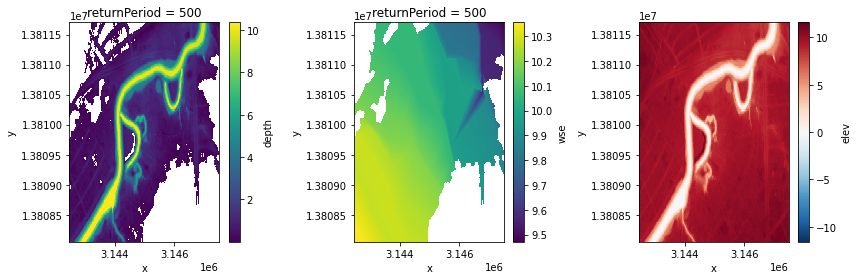

In [9]:
input_rasters = generate_depth_elev_ds(
            flood_rasters_path_list = flood_rasters_path_list,
            input_return_periods = raster_return_periods,
            elevation_raster = elevation_raster,
            depth_or_wse = depth_or_wse,
            depth_units = ['ft']*len(flood_rasters_path_list),
            dem_units = 'ft',
            verbose = 1)
input_rasters_deepcopy = input_rasters.copy(deep=True)
fig, axes = plt.subplots(ncols=3,figsize=(12,4))
input_rasters.depth.isel(returnPeriod=3).plot.imshow(ax=axes[0])
input_rasters.wse.isel(returnPeriod=3).plot.imshow(ax=axes[1])
input_rasters.elev.plot.imshow(ax=axes[2])
plt.tight_layout()
plt.draw()

### STEP 2: backfill NaNs

In [10]:
%%time
# Backfill NaNs
input_rasters_wse_backfilled = backfill_nan_with_nearest(input_rasters.wse)

# Put NaNs back in cells that the largest return period is NaN
input_rasters_wse_backfilled = input_rasters.where(input_rasters_deepcopy.wse.isel(returnPeriod=len(input_rasters_deepcopy.returnPeriod)-1) > -1000,np.nan)

# Save the backfilled data 
input_rasters_wse_backfilled.to_netcdf(f'backfilled_{area_name}.nc')

4
Received an array with shape (465, 338, 4) for backfilling
0
(20295, 2) (136875, 2)
1
(25870, 2) (131300, 2)
2
(32046, 2) (125124, 2)
3
(120356, 2) (36814, 2)
CPU times: user 3min 46s, sys: 24.4 ms, total: 3min 46s
Wall time: 3min 46s


### STEP 3: run FLOPIT 

In [11]:
%%time
#for m in ['log-linear','linear','spline','log-spline']:
for m in ['log-spline']:
        FLOPIT_preProcessed(
           input_rasters_wse_backfilled,
           input_return_periods = raster_return_periods , 
           elevation_raster = elevation_raster,
           interpolation_method = m,
           aep_raster_generate = 1,
           aep_map_generate = 1,
           flood_zone_return_period = [20,200],
           flood_zone_raster_generate = 1,
           flood_zone_map_generate = 1,
           extrapolate = 0,
           input_dem_plot_generate = 0,
           input_depth_plot_generate = 0,
           output_data_dir = 'output_data',
           output_plot_dir = 'output_plots',
           sample_point = None,
           areaName = area_name,
           verbose=1,
          )

Starting the interpolation using the "Log-Spline" method...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in power


Finished the interpolation
Converted AEP values greater than 0.1 to 0.1 and values less than 0.002 to NaN
Saving the AEP plot to ...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:149: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Generating output for 2 new return periods:[20, 200]
Checking the validity of the return periods...
Starting the interpolation of water surface elevation for return period 20 using Log-Spline method...
Finished the interpolation of water surface elevation for the requested new return period: 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:269: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:279: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:288: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y,

Starting the interpolation of water surface elevation for return period 200 using Log-Spline method...
Finished the interpolation of water surface elevation for the requested new return period: 200


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:269: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:279: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:288: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y,

CPU times: user 1min 23s, sys: 173 ms, total: 1min 23s
Wall time: 1min 24s


## Cross Validation

In [34]:

flood_rasters_path_list_houston = ['input_data/houston/wse_10pct_clipped_resampled.tif',
                                   'input_data/houston/wse_2pct_clipped_resampled.tif',
                                   'input_data/houston/wse_02pct_clipped_resampled.tif']
raster_return_periods_houston = np.array([10,50,500])
elevation_raster_path_houston = 'input_data/houston/ned19_n29x75_w095x50_tx_houstoncity_2008_clipped_feet.tif'
depth_or_wse_houston = 'wse'
area_name_houston = 'houston'

area_name = area_name_houston
raster_return_periods = raster_return_periods_houston
flood_rasters_path_list = flood_rasters_path_list_houston
depth_or_wse = depth_or_wse_houston
elevation_raster = elevation_raster_path_houston

In [38]:
%%time
'''
#for m in ['log-linear','linear','spline','log-spline']:
for m in ['log-spline']:
        FLOPIT_preProcessed(
           input_rasters_wse_backfilled ,
           input_return_periods = raster_return_periods , 
           elevation_raster = elevation_raster,
           interpolation_method = m,
           aep_raster_generate = 1,
           aep_map_generate = 1,
           flood_zone_return_period = [100],
           flood_zone_raster_generate = 1,
           flood_zone_map_generate = 1,
           extrapolate = 0,
           input_dem_plot_generate = 0,
           input_depth_plot_generate = 0,
           output_data_dir = 'output_data',
           output_plot_dir = 'output_plots',
           sample_point = None,
           areaName = 'houstonCV',
           verbose=1,
          )
        
'''        

#for m in ['log-spline','log-linear','linear','spline']:
for m in ['log-spline']:
        FLOPIT(
           flood_rasters_path_list = flood_rasters_path_list,
           input_return_periods = raster_return_periods , 
           elevation_raster = elevation_raster,
           depth_or_wse = depth_or_wse,
           depth_units = ['ft']*len(flood_rasters_path_list),
           dem_units = 'ft',
           interpolation_method = m,
           aep_raster_generate = 1,
           aep_map_generate = 1,
           flood_zone_return_period = [100],
           flood_zone_raster_generate = 1,
           flood_zone_map_generate = 1,
           extrapolate = 0,
           input_dem_plot_generate = 0,
           input_depth_plot_generate = 0,
           output_data_dir = 'output_data',
           output_plot_dir = 'output_plots',
           sample_point = None,
           backfill_nans = True,
           areaName = 'houstonCV',
           verbose=1,
          )


Received 3 rasters
reading raster input_data/houston/wse_10pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_10pct_clipped_resampled.tif are in "feet". Converting them to meters
reading raster input_data/houston/wse_2pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_2pct_clipped_resampled.tif are in "feet". Converting them to meters
reading raster input_data/houston/wse_02pct_clipped_resampled.tif
Received data for raster input_data/houston/wse_02pct_clipped_resampled.tif are in "feet". Converting them to meters
Received DEM data are in "feet". Converting them to meters
Received data are water surface elevations...
Backfilling the NaNs with data from nearest neighbor cell...
3
Received an array with shape (465, 338, 3) for backfilling
0
(20295, 2) (136875, 2)
1
(25870, 2) (131300, 2)
2
(120356, 2) (36814, 2)
Starting the interpolation using the "Log-Spline" method...
Finished the interpolation
Converted AEP values greater than 0.1 to 0.1 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Generating output for 1 new return periods:[100]
Checking the validity of the return periods...
Starting the interpolation of water surface elevation for return period 100 using Log-Spline method...
Finished the interpolation of water surface elevation for the requested new return period: 100


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:289: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:299: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:308: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y,

CPU times: user 3min 36s, sys: 107 ms, total: 3min 36s
Wall time: 3min 37s


# System characteristics

In [7]:
import platform
import psutil

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print('processor=',platform.processor())
str(round(psutil.virtual_memory().total / (1024.0 **3)))
# let's print CPU information
print("="*40, "CPU Info", "="*40)
# number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))
# CPU frequencies
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
# CPU usage
#print("CPU Usage Per Core:")
#for i, percentage in enumerate(psutil.cpu_percent(percpu=True, interval=1)):
#    print(f"Core {i}: {percentage}%")
print(f"Total CPU Usage: {psutil.cpu_percent()}%")

x86_64
#7-Ubuntu SMP Tue Apr 24 10:56:17 UTC 2018
Linux-4.15.0-1007-aws-x86_64-with-debian-10.2
uname_result(system='Linux', node='ce5af42f1c59', release='4.15.0-1007-aws', version='#7-Ubuntu SMP Tue Apr 24 10:56:17 UTC 2018', machine='x86_64', processor='')
Linux
processor= 
======================================== CPU Info ========================================
Physical cores: 24
Total cores: 48
Max Frequency: 0.00Mhz
Min Frequency: 0.00Mhz
Current Frequency: 1789.69Mhz
Total CPU Usage: 2.1%


# Track time

In [15]:
import time
durations = np.zeros((4,1),float)

for i,m in enumerate(['log-spline','log-linear','linear','spline']):
    for j in range(1):
        print(i,j)
        start_time = time.time()
        FLOPIT_preProcessed(
           input_rasters_wse_backfilled,
           input_return_periods = raster_return_periods , 
           elevation_raster = elevation_raster,
           interpolation_method = m,
           aep_raster_generate = 0,
           aep_map_generate = 0,
           flood_zone_return_period = None,
           flood_zone_raster_generate = 0,
           flood_zone_map_generate = 0,
           extrapolate = 0,
           input_dem_plot_generate = 0,
           input_depth_plot_generate = 0,
           output_data_dir = 'output_data',
           output_plot_dir = 'output_plots',
           sample_point = None,
           areaName = 'None',
           verbose=0,
          )
        end_time = time.time()
        dur = end_time - start_time
        durations[i,j]=dur

print(durations)

0 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in power


1 0


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


2 0
3 0
[[140.97323871]
 [119.75479937]
 [ 97.92195487]
 [117.40474582]]


# Find best regression method 

In [39]:
biases = []
flood_rasters_path_list = ['input_data/muncy/depth_10pct_projected_clipped.tif',
                           'input_data/muncy/depth_01pctprojected_clipped.tif',
                           'input_data/muncy/depth_0_2pct_projected_clipped.tif']
elevation_raster_path = 'input_data/muncy/Muncy_dem_resampled.tif'

raster_return_periods = np.array([10,100,500])

for m in ['log-spline','log-linear','linear','spline']:
    print(m)
    FLOPIT(flood_rasters_path_list = flood_rasters_path_list,
           input_return_periods = raster_return_periods , 
           elevation_raster = elevation_raster_path,
           depth_or_wse = 'wse',
           depth_units = ['ft']*len(flood_rasters_path_list),
           dem_units = 'ft',
           interpolation_method = m,
           aep_raster_generate = 0,
           aep_map_generate = 0,
           flood_zone_return_period = [50],
           flood_zone_raster_generate = 1,
           flood_zone_map_generate = 0,
           extrapolate = 0,
           input_dem_plot_generate = 0,
           input_depth_plot_generate = 0,
           output_data_dir = 'output_data',
           output_plot_dir = 'output_plots',
           sample_point = None,
           backfill_nans = True,
           areaName = 'muncyBestInt',
           verbose = 0,
          )
    obs_path = "input_data/muncy/wse_1pct_clipped_resampled.tif"
    pred_path = f"output_data/estimated_wse_data_rp_50_{m}_houstonBestInt.tif"

    # Pre-process the observed inputs 
    obs = xarray.open_rasterio(obs_path).isel(band=0)
    obs = obs * 0.3048
    obs = obs.where(obs > -100, np.nan)
    pred = xarray.open_rasterio(pred_path).isel(band=0)
    pred.coords['x'] = obs.coords['x']
    pred.coords['y'] = obs.coords['y']
    diff = obs - pred
    biases.append(diff)
    

log-spline
3
Received an array with shape (465, 338, 3) for backfilling
0
(20295, 2) (136875, 2)
1
(32046, 2) (125124, 2)
2
(120356, 2) (36814, 2)
log-linear
3
Received an array with shape (465, 338, 3) for backfilling
0
(20295, 2) (136875, 2)
1
(32046, 2) (125124, 2)
2
(120356, 2) (36814, 2)
linear
3
Received an array with shape (465, 338, 3) for backfilling
0
(20295, 2) (136875, 2)
1
(32046, 2) (125124, 2)
2
(120356, 2) (36814, 2)
spline
3
Received an array with shape (465, 338, 3) for backfilling
0
(20295, 2) (136875, 2)
1
(32046, 2) (125124, 2)
2
(120356, 2) (36814, 2)


In [40]:
biases = xarray.concat(biases,dim='method')
biases.coords['method'] = ['log-spline','log-linear','linear','spline']
biases

<xarray.DataArray (method: 4, y: 338, x: 465)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 1.381e+07 1.381e+07 1.381e+07 ... 1.381e+07 1.381e+07
  * x        (x) float64 3.142e+06 3.142e+06 3.143e+06 ... 3.147e+06 3.147e+06
  * method   (method) <U10 'log-spline' 'log-linear' 'linear' 'spline'

In [41]:
means = biases.mean(dim=['x','y'],skipna=True)
means.values

array([0.7291175 , 0.76661134, 1.4148716 , 1.3133267 ], dtype=float32)

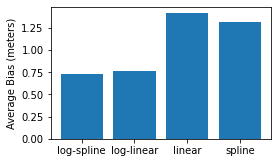

In [42]:
plt.figure(figsize=(3.95,2.43))
plt.bar(x=['log-spline','log-linear','linear','spline'],height = means.values)
plt.ylabel('Average Bias (meters)')
plt.savefig('average_biase_cross_validation.png',dpi=300)

In [43]:
biases_stacked = biases.stack(point=('x','y'))
biases_stacked = biases_stacked.load()

# Compare FLOPIT water surface elevation with FEMA WSE

Obs Min= 8.029543
Obs Max= 9.049456
Pred Min= 7.794366
Pred Max= 8.811335
0.094742775
0.25673527
0.33123875


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or

(array([7.0000e+00, 6.0000e+00, 8.0000e+00, 1.0000e+01, 2.5000e+01,
        4.0730e+03, 1.4891e+04, 5.1610e+03, 4.5370e+03, 7.0000e+01]),
 array([0.09474277, 0.11839237, 0.14204197, 0.16569157, 0.18934116,
        0.21299076, 0.23664036, 0.26028997, 0.28393954, 0.30758914,
        0.33123875], dtype=float32),
 <BarContainer object of 10 artists>)

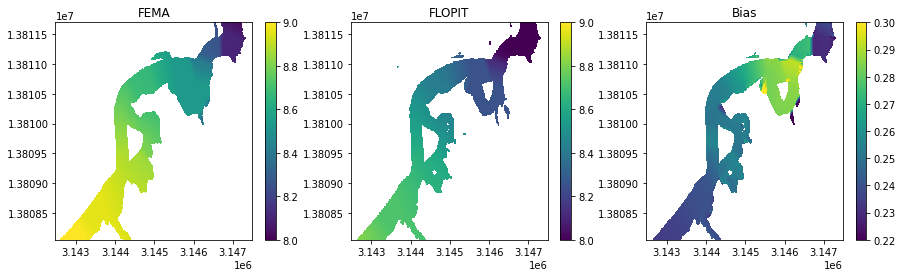

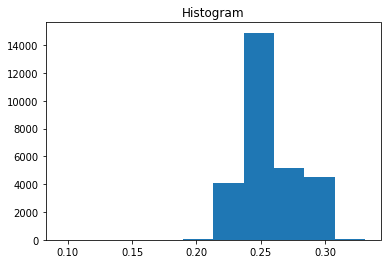

In [60]:
obs_path = "input_data/houston/wse_1pct_clipped_resampled.tif"
pred_path = "output_data/estimated_wse_data_rp_100_log-linear_houston.tif"

# Pre-process the observed inputs 
obs = xarray.open_rasterio(obs_path).isel(band=0)
obs = obs * 0.3048
obs = obs.where(obs > -100, np.nan)
print('Obs Min=',obs.min().values)
print('Obs Max=',obs.max().values)

# Pre-process the predicted inputs 
pred = xarray.open_rasterio(pred_path).isel(band=0)
print('Pred Min=',pred.min().values)
print('Pred Max=',pred.max().values)

# Calculate their difference
pred.coords['x'] = obs.coords['x']
pred.coords['y'] = obs.coords['y']
diff = obs - pred
print(diff.min(skipna=True).values)
print(diff.mean(skipna=True).values)
print(diff.max(skipna=True).values)

# Plot 
plt.figure(figsize=(15,4))
    
plt.subplot(1,3,1)
plt.pcolor(obs.x,obs.y,obs,vmin=8,vmax=9)
plt.colorbar()
plt.title('FEMA')

plt.subplot(1,3,2)
plt.pcolor(pred.x,pred.y,pred,vmin=8,vmax=9)
plt.colorbar()
plt.title('FLOPIT')

plt.subplot(1,3,3)
plt.pcolor(diff.x,diff.y,diff,vmin=0.22,vmax=0.3)
plt.colorbar()
plt.title('Bias')
#plt.savefig('error.png')

plt.figure()
xarray.plot.hist(diff)    


[array(0.09474277, dtype=float32), array(0.25673527, dtype=float32), array(0.33123875, dtype=float32)]


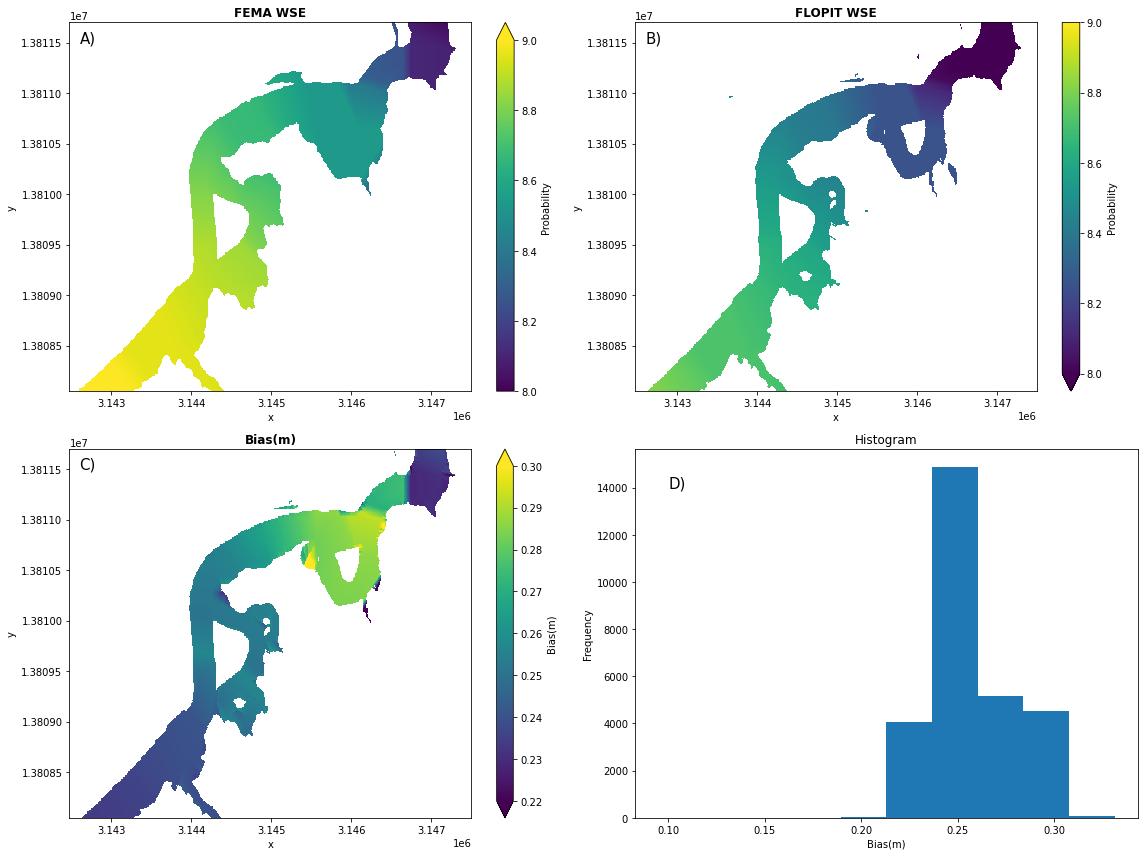

In [65]:
ig, ((ax0, ax1), (ax2, ax3))  = plt.subplots(nrows=2,ncols=2,figsize=(16,12))

obs.plot.imshow(ax=ax0,vmin=8,vmax=9,cbar_kwargs={'label': 'Probability'})
pred.plot.imshow(ax=ax1,vmin=8,vmax=9,cbar_kwargs={'label': 'Probability'})
diff.plot.imshow(ax=ax2,vmin=0.22,vmax=0.3,cbar_kwargs={'label': 'Bias(m)'})
xarray.plot.hist(diff,ax=ax3)

ax2.set_title('Histogram of Bias over the area',fontweight='bold')
ax2.set_title('Bias(m)',fontweight='bold')
ax0.set_title('FEMA WSE',fontweight='bold')
ax1.set_title('FLOPIT WSE',fontweight='bold')

ax3.set_xlabel('Bias(m)')
ax3.set_ylabel('Frequency')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax0.text(3.1426e6,1.38115e7,'A)',color='black', fontsize=15)
ax1.text(3.1426e6,1.38115e7,'B)',color='black', fontsize=15)
ax2.text(3.1426e6,1.38115e7,'C)',color='black', fontsize=15)
ax3.text(0.1,14000,'D)',color='black', fontsize=15)

print([diff.min().values,diff.mean().values,diff.max().values])

# Make it nice
plt.tight_layout()


plt.savefig('paper_plots/wse_100yr_comparison.png',dpi=300)

# Compare FLOPIT AEP with FEMA pctannchance for Houston

Obs Min= 6.2563313e-06
Obs Max= 0.1
Pred Min= 0.002
Pred Max= 0.1
-0.08859582


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or

-0.08859582
-0.0011265409
0.08698449


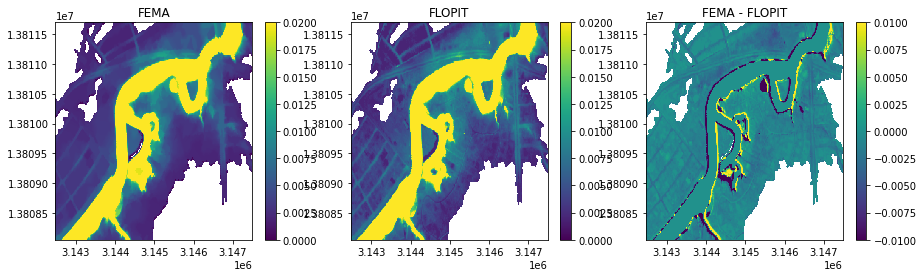

In [22]:
obs_path = "input_data/houston/pctannchance_clipped_resampled.tif"
pred_path = "output_data/aep_log-linear_houston.tif"

# Pre-process the observed inputs 
obs = xarray.open_rasterio(obs_path).isel(band=0)
obs = obs.where(obs > 0.0000001, np.nan)
print('Obs Min=',obs.min().values)
print('Obs Max=',obs.max().values)

# Pre-process the predicted inputs 
pred = xarray.open_rasterio(pred_path).isel(band=0)
#pred = pred.where(pred != np.Inf, np.nan)
pred = pred.where(pred > obs.min(skipna=True),np.nan)
#pred = pred.where(pred <= 1, 1)
#pred.plot.hist()
print('Pred Min=',pred.min().values)
print('Pred Max=',pred.max().values)


# Calculate their difference
pred.coords['x'] = obs.coords['x']
pred.coords['y'] = obs.coords['y']
diff = obs - pred
print(np.nanmin(obs.values - pred.values))
# Plot 
plt.figure(figsize=(15,4))
    
plt.subplot(1,3,1)
plt.pcolor(obs.x,obs.y,obs,vmin=0,vmax=0.02)
plt.colorbar()
plt.title('FEMA')

plt.subplot(1,3,2)
plt.pcolor(pred.x,pred.y,pred,vmin=0,vmax=0.02)
plt.colorbar()
plt.title('FLOPIT')

plt.subplot(1,3,3)
plt.pcolor(diff.x,diff.y,diff,vmin=-0.01,vmax=0.01)
plt.colorbar()
plt.title('FEMA - FLOPIT')
plt.savefig('error.png')

print(diff.min(skipna=True).values)
print(diff.mean(skipna=True).values)
print(diff.max(skipna=True).values)


[array(-0.08859582, dtype=float32), array(-0.00112654, dtype=float32), array(0.08698449, dtype=float32)]


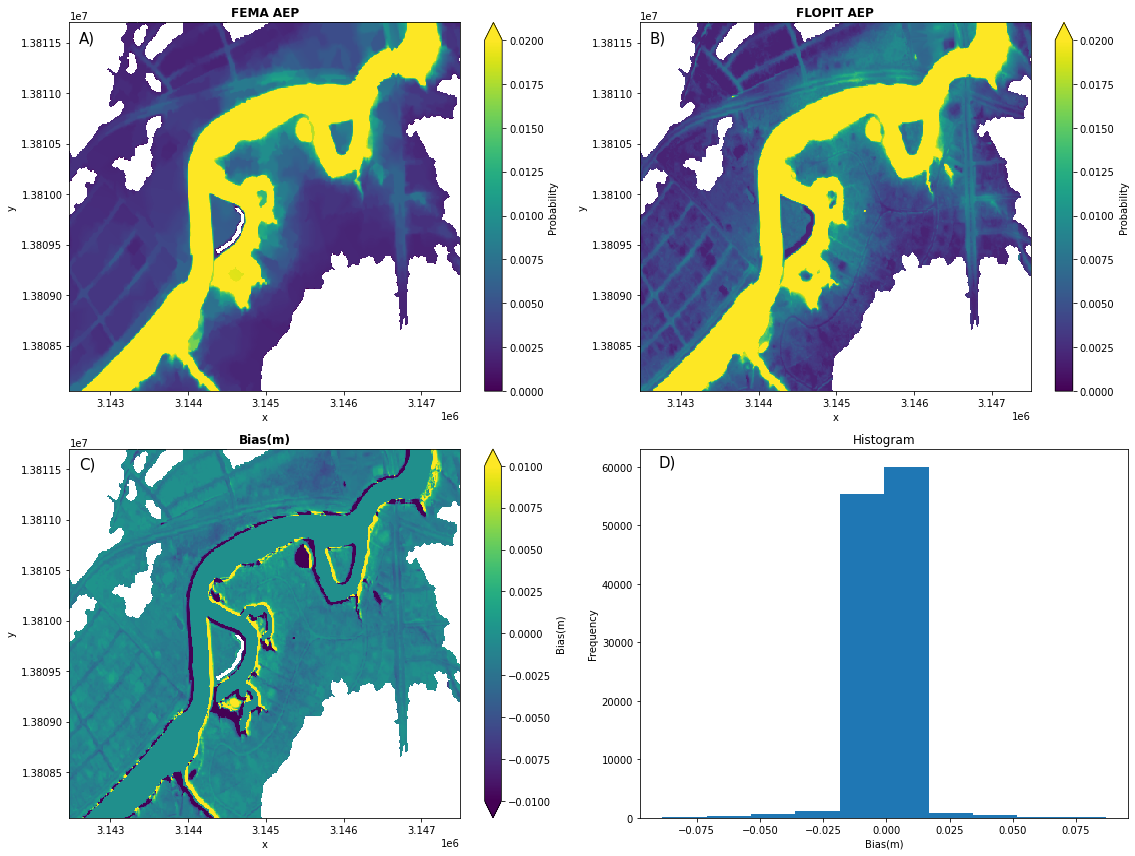

In [59]:
fig, ((ax0, ax1), (ax2, ax3))  = plt.subplots(nrows=2,ncols=2,figsize=(16,12))

obs.plot.imshow(ax=ax0,vmin=0,vmax=0.02,cbar_kwargs={'label': 'Probability'})
pred.plot.imshow(ax=ax1,vmin=0,vmax=0.02,cbar_kwargs={'label': 'Probability'})
diff.plot.imshow(ax=ax2,vmin=-0.01,vmax=0.01,cbar_kwargs={'label': 'Bias(m)'})
xarray.plot.hist(diff,ax=ax3)

ax2.set_title('Histogram of Bias over the area',fontweight='bold')
ax2.set_title('Bias(m)',fontweight='bold')
ax0.set_title('FEMA AEP',fontweight='bold')
ax1.set_title('FLOPIT AEP',fontweight='bold')

ax3.set_xlabel('Bias(m)')
ax3.set_ylabel('Frequency')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax0.text(3.1426e6,1.38115e7,'A)',color='black', fontsize=15)
ax1.text(3.1426e6,1.38115e7,'B)',color='black', fontsize=15)
ax2.text(3.1426e6,1.38115e7,'C)',color='black', fontsize=15)
ax3.text(-0.09,60000,'D)',color='black', fontsize=15)

print([diff.min().values,diff.mean().values,diff.max().values])

# Make it nice
plt.tight_layout()


plt.savefig('paper_plots/histogram_ead_bias.png',dpi=300)

# EAD analysis

In [ ]:
DD_depth = np.array([-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
DD_damage = np.array([0,0,4,8,12,15,20,23,28,33,37,43,48,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81])/100

flood_rasters_path_list = ['input_data/wse_10pct_clipped_resampled.tif',
                           'input_data/wse_2pct_clipped_resampled.tif',
                           'input_data/wse_1pct_clipped_resampled.tif',
                           'input_data/wse_02pct_clipped_resampled.tif']
elevation_raster_path = 'input_data/ned19_n29x75_w095x50_tx_houstoncity_2008_clipped_feet.tif'
raster_return_periods = np.array([10,50,100,500])
depth_or_wse = 'wse' # water surface elevation

print('\n\n********* Without Interpolation *************')
point_EAD(DD_depth,
              DD_damage,
              flood_rasters_path_list,
              elevation_raster_path,
              raster_return_periods,
              depth_or_wse,
              point_lat=13810613.9516129,
              point_lon=3144641.69354839,
              output_plot_dir = 'output_plots',
              Struc_Value = 300000,
              depth_units = ['ft']*4,
              dem_units = 'ft',
             )


print('\n\n********* With Interpolation *************')
flood_rasters_path_list = ['input_data/wse_10pct_clipped_resampled.tif', #10-yr
                           'output_data/estimated_wse_data_rp_20.tif',  #20-yr
                           'input_data/wse_2pct_clipped_resampled.tif',  #50-yr
                           'input_data/wse_1pct_clipped_resampled.tif',  #100-yr
                           'output_data/estimated_wse_data_rp_200.tif',  #200-yr
                           'input_data/wse_02pct_clipped_resampled.tif'  #500-yr
                          ]
elevation_raster_path = 'input_data/ned19_n29x75_w095x50_tx_houstoncity_2008_clipped_feet.tif'
raster_return_periods = np.array([10,20,50,100,200,500])
depth_or_wse = 'wse' # water surface elevation

point_EAD(DD_depth,
              DD_damage,
              flood_rasters_path_list,
              elevation_raster_path,
              raster_return_periods,
              depth_or_wse,
              point_lat=13810613.9516129,
              point_lon=3144641.69354839,
              output_plot_dir = 'output_plots',
              Struc_Value = 300000,
              depth_units = ['ft','m','ft','ft','m','ft'],
              dem_units = 'ft',
             )
